In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('../datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [42]:
len(words)

32033

In [43]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [44]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  #for w in words:
  for w in words[:5]:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

X, Y = build_dataset(words)

torch.Size([32, 3]) torch.Size([32])


In [ ]:
# create the embedding matrix
C = torch.randn((27, 2))
emb = C[X]
print(emb.shape)

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# generating the embeddings in different ways
embv1 = torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]])
print(f"{embv1.shape=}")

embv2 = torch.cat(torch.unbind(emb, dim=1))
print(f"{embv2.shape=}")

# torch.cat is inefficient as it creates a new tensor with new memory, instead we can use view which just changes the shape of the existing tensor in the memory
embv3 = emb.view(32, 6)
print(f"{embv3.shape=}")

embv4 = emb.view(-1, 6)
print(f"{embv4.shape=}")

print(f"Internal torch tensor representation: {emb.storage().tolist()[:5]}")

# now we can use the embeddings to compute the hidden layer
h = embv3 @ W1 + b1
print(h.shape)

torch.Size([32, 3, 2])
embv1.shape=torch.Size([96, 2])
embv2.shape=torch.Size([96, 2])
embv3.shape=torch.Size([32, 6])
embv4.shape=torch.Size([32, 6])
Internal torch tensor representation: [-0.1281909942626953, 1.7713350057601929, -0.1281909942626953, 1.7713350057601929, -0.1281909942626953]
torch.Size([32, 100])


In [ ]:
# Simple softmax example
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
print([-5, -3, 0, 5])
print(probs)
print("-----------------------------")
# Softmax suffers from numerical instability when logits are large or small (in particular, has problems with large positive logits)
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
print([-5, -3, 0, 5])
print(probs)
print("-----------------------------")
# To fix the problem, we can subtract the maximum logit from all logits, the probability distribution remains the same
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
print([-5, -3, 0, 5])
print(probs)
print("-----------------------------")
# In PyTorch, we can use the built-in softmax function which handles numerical stability internally and other optimizations
probs = F.softmax(torch.tensor([-100, -3, 0, 100]).float())
print(probs)

[-5, -3, 0, 5]
tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
-----------------------------
[-5, -3, 0, 5]
tensor([0., 0., 0., nan])
-----------------------------
[-5, -3, 0, 5]
tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])
-----------------------------
tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])


/tmp/ipython-input-210467475.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor([-100, -3, 0, 100]).float())


In [ ]:
# Creating train/dev/test splits
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([36, 3]) torch.Size([36])
torch.Size([30, 3]) torch.Size([30])
torch.Size([35, 3]) torch.Size([35])


In [ ]:
def init_network():
    g = torch.Generator().manual_seed(2147483647)
    # By increasing the size of the embedding matrix, we can improve the model's ability to learn complex relationships, 
    # but a more complex model tends to overfit more easily by perfectly describing the training data
    C = torch.randn((27, 10), generator=g)
    W1 = torch.randn((30, 200), generator=g)
    b1 = torch.randn(200, generator=g)
    W2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    return g, C, W1, b1, W2, b2, parameters
g, C, W1, b1, W2, b2, parameters = init_network()

In [ ]:
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [ ]:
# Comparison of exponential (starts to grow slow, then bacome fast) vs linear lr deacay
lre = torch.linspace(-3, 0, 1000)
lre = 10**lre

lrl = torch.linspace(0.001, 1, 1000)

def train_model(lrs):
    lri = []
    lossi = []
    stepi = []

    for i in range(1000):
        # minibatch construct
        # note: a larger batch size leads to more stable gradients, but also requires more memory
        ix = torch.randint(0, Xtr.shape[0], (32,))

        # forward pass
        emb = C[Xtr[ix]] # (32, 3, 2)
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Ytr[ix])

        # Even if the loss is very low, it's impossible for it to get further closer to 0, 
        # mainly because there are cases like "...[c]" where three dots are followed by the initial name's char, 
        # but as this initial char is often different, it's impossible to overfit it
        if i % 100 == 0:
            print(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = lrs[i]
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        lri.append(lre[i])
        stepi.append(i)
        lossi.append(loss.log10().item())
    return lri, stepi, lossi

24.342132568359375
14.473780632019043
8.117585182189941
0.7045519948005676
0.3620147109031677
0.30919334292411804
0.1796647012233734
0.330991268157959
0.43048810958862305
1.3572115898132324
22.814716339111328
6.422578007914126e-05
0.16005854308605194
0.33275434374809265
0.12080226838588715
0.2702902555465698
0.1419288069009781
0.2759486734867096
0.19406741857528687
0.31778162717819214


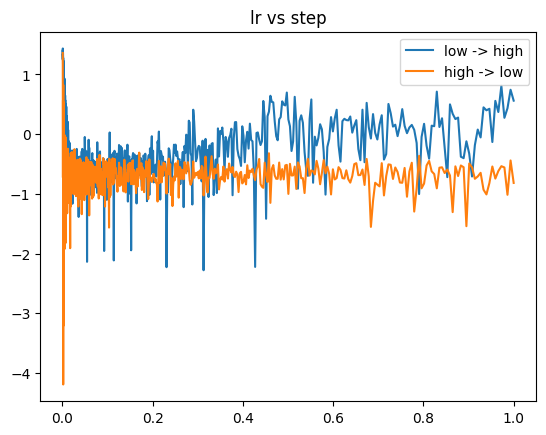

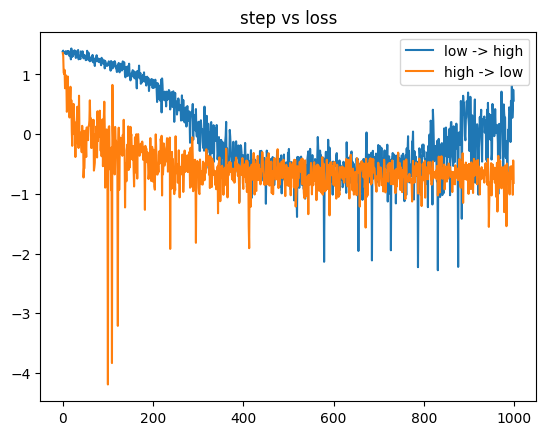

In [84]:
# lr lower to higher
g, C, W1, b1, W2, b2, parameters = init_network()

lrilh, stepilh, lossilh = train_model(lre)
plt.plot(lrilh, lossilh, label="low -> high")

# lr higher to lower
g, C, W1, b1, W2, b2, parameters = init_network()

lrihl, stepihl, lossihl = train_model(sorted(lre, reverse=True))
plt.plot(lrihl, lossihl, label="high -> low")

plt.title("lr vs step")
plt.legend()
plt.show()

plt.plot(stepilh, lossilh, label="low -> high")
plt.plot(stepihl, lossihl, label="high -> low")
plt.title("step vs loss")
plt.legend()
plt.show()

23.15379524230957
0.4636472463607788
0.25061818957328796
0.6991285681724548
0.44989874958992004
0.9874320030212402
1.494692087173462
2.212679386138916
0.045599810779094696
2.196413040161133
19.193880081176758
5.207186222076416
1.8009746074676514
2.1899101734161377
1.1111807823181152
0.2450084388256073
1.491705298423767
0.24421629309654236
0.3112051784992218
0.40733200311660767


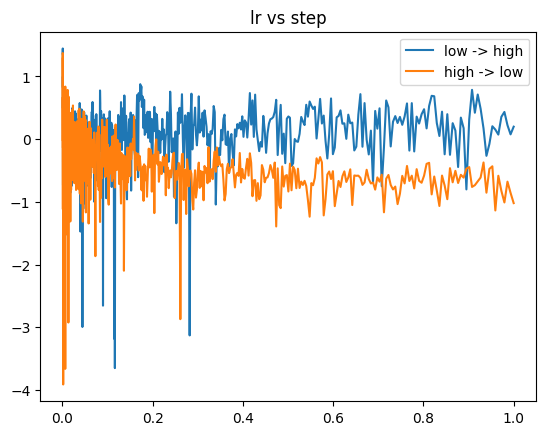

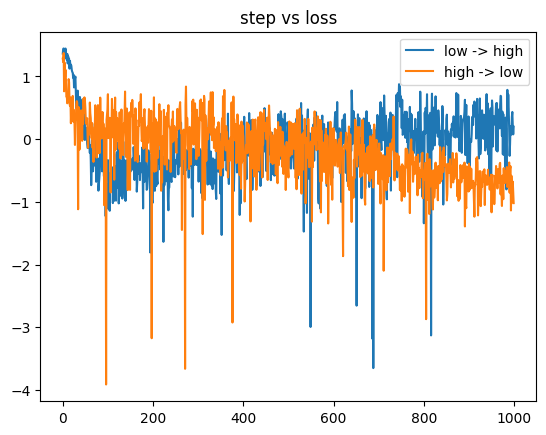

In [82]:
# lr lower to higher
g, C, W1, b1, W2, b2, parameters = init_network()

lrilh, stepilh, lossilh = train_model(lrl)
plt.plot(lrilh, lossilh, label="low -> high")

# lr higher to lower
g, C, W1, b1, W2, b2, parameters = init_network()

lrihl, stepihl, lossihl = train_model(sorted(lrl, reverse=True))
plt.plot(lrihl, lossihl, label="high -> low")

plt.title("lr vs step")
plt.legend()
plt.show()

plt.plot(stepilh, lossilh, label="low -> high")
plt.plot(stepihl, lossihl, label="high -> low")
plt.title("step vs loss")
plt.legend()
plt.show()

A good way to choose a right stable lr is to use SGD, and for each batch choose a different lr, then look at the loss progress, and choose a lr where the loss is steady low


In [85]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.2240, grad_fn=<NllLossBackward0>)

In [86]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(22.1059, grad_fn=<NllLossBackward0>)

In [87]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(19.3964, grad_fn=<NllLossBackward0>)

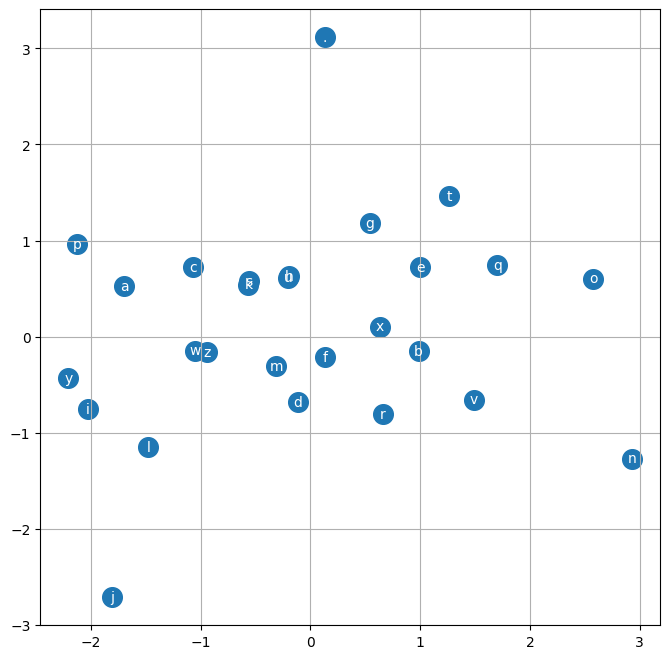

In [88]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all zeros (i.e. three dots)
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

jori.
yuheng.
juanluis.
jori.
juanluis.
diondre.
yuheng.
juanluis.
diondre.
xavien.
yuheng.
xavien.
diondre.
juanluis.
jori.
jori.
xavien.
diondre.
yuheng.
diondre.
